<a href="https://colab.research.google.com/github/shalabh147/Brain-Tumor-Segmentation-and-Survival-Prediction-using-Deep-Neural-Networks/blob/master/3d_vnet_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
#import tensorflow as tf
import keras.backend as K
import keras
import nibabel as nib

from keras.models import Model, load_model
#from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
#from keras.layers.core import Lambda, RepeatVector, Reshape
#from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
#from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
#from keras.layers.merge import concatenate, add
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#from skimage.io import imread, imshow, concatenate_images
#from skimage.transform import resize
avg_sens = [0,0,0,0]
avg_spec = [0,0,0,0]
def standardize(image):

  standardized_image = np.zeros(image.shape)

  #
  
      # iterate over the `z` dimension
  for z in range(image.shape[2]):
      # get a slice of the image 
      # at channel c and z-th dimension `z`
      image_slice = image[:,:,z]

      # subtract the mean from image_slice
      centered = image_slice - np.mean(image_slice)
      
      # divide by the standard deviation (only if it is different from zero)
      if(np.std(centered)!=0):
          centered = centered/np.std(centered) 

      # update  the slice of standardized image
      # with the scaled centered and scaled image
      standardized_image[:, :, z] = centered

  ### END CODE HERE ###

  return standardized_image


def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.
    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.
    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    # extract sub-array for specified class
    class_pred = pred[0,:,:,:,class_num]
    class_label = label[0,:,:,:,class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute true positives, false positives, 
    # true negatives, false negatives
    tp = np.sum((class_pred == 1) & (class_label == 1))
    tn = np.sum((class_pred == 0) & (class_label == 0))
    fp = np.sum((class_pred == 1) & (class_label == 0))
    fn = np.sum((class_pred == 0) & (class_label == 1))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    ### END CODE HERE ###

    return sensitivity, specificity


def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Nothing',
                    'Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        avg_sens[i] += sens
        avg_spec[i] += spec
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    #return patch_metrics


import os
model = load_model('../input/evaluate-vnet/Vnet_model.h5',custom_objects = {'dice_coef_loss' : dice_coef_loss , 'dice_coef' : dice_coef})


In [ ]:
path = '../input/vs-brats2018/miccai_brats_2018_data_training/HGG'
all_images = os.listdir(path)
#print(len(all_images))
all_images.sort()
data = np.zeros((240,240,155,4))
image_data2=np.zeros((240,240,155))


In [ ]:
loss_list = []
accu_list = []
mean_loss = 0
mean_accu = 0
import nibabel as nib
for image_num in range(180,210):
    #print(epochs)
    print("Entering Image" , image_num)

# data preprocessing starts here

    x = all_images[image_num]
    #print(x)
    folder_path = path + '/' + x;
    modalities = os.listdir(folder_path)
    modalities.sort()
    #data = []
    w = 0
    for j in range(len(modalities)):
      #print(modalities[j])
      
      image_path = folder_path + '/' + modalities[j]
      if not(image_path.find('seg.nii') == -1):
        img = nib.load(image_path);
        image_data2 = img.get_data()
        image_data2 = np.asarray(image_data2)
        #print("Entered ground truth")
      else:
        img = nib.load(image_path);
        image_data = img.get_data()
        image_data = np.asarray(image_data)
        image_data = standardize(image_data)
        data[:,:,:,w] = image_data
        #print("Entered modality")
        w = w+1
      
    #print(data.shape)
    #print(image_data2.shape)  

    reshaped_data=data[56:184,75:203,13:141,:]
    reshaped_data=reshaped_data.reshape(1,128,128,128,4)
    reshaped_image_data2=image_data2[56:184,75:203,13:141]

        
    reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
    reshaped_image_data2[reshaped_image_data2==4] = 3
    #hello = reshaped_image_data2.flatten()
    #y_to = keras.utils.to_categorical(y_to,num_classes=2)
    #print(reshaped_image_data2.shape)
    #print(hello[hello==3].shape)
    #print("Number of classes",np.unique(hello))
    #class_weights = class_weight.compute_class_weight('balanced',np.unique(hello),hello)
    #print(class_weights)

    reshaped_image_data2 = keras.utils.to_categorical(reshaped_image_data2, num_classes = 4)
    Y_hat = model.predict(x=reshaped_data)
    Y_hat = np.argmax(Y_hat,axis = -1)
    
    Y_hat = keras.utils.to_categorical(Y_hat)
    get_sens_spec_df(Y_hat,reshaped_image_data2)

    #print(reshaped_data.shape)
    #print(reshaped_image_data2.shape)
    #print(type(reshaped_data))
    print("Processed Image" , image_num)
    
    scores = model.evaluate(x=reshaped_data,y=reshaped_image_data2)
    loss_list.append(scores[0])
    accu_list.append(scores[1])
    #print(scores[1])
    mean_loss += scores[0]
    mean_accu += scores[1]
    #print(scores[1])
    
print()
print("Mean Dice Loss" , mean_loss/30)
print("Mean Dice Coefficient(Accuracy)" , mean_accu/30)
print()
print("Mean Sensitivity for class 0" , avg_sens[0]/30)
print("Mean Specificity for class 0" , avg_spec[0]/30)
print()
print("Mean Sensitivity for class 1" , avg_sens[1]/30)
print("Mean Specificity for class 1" , avg_spec[1]/30)
print()
print("Mean Sensitivity for class 2" , avg_sens[2]/30)
print("Mean Specificity for class 2" , avg_spec[2]/30)
print()
print("Mean Sensitivity for class 3" , avg_sens[3]/30)
print("Mean Specificity for class 3" , avg_spec[3]/30)




Entering Image 180


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Processed Image 180
1/1 [==============================] - 1s 593ms/step
Entering Image 181
Processed Image 181
1/1 [==============================] - 0s 217ms/step
Entering Image 182
Processed Image 182
1/1 [==============================] - 0s 216ms/step
Entering Image 183
Processed Image 183
1/1 [==============================] - 0s 216ms/step
Entering Image 184
Processed Image 184
1/1 [==============================] - 0s 217ms/step
Entering Image 185
Processed Image 185
1/1 [==============================] - 0s 216ms/step
Entering Image 186
Processed Image 186
1/1 [==============================] - 0s 217ms/step
Entering Image 187
Processed Image 187
1/1 [==============================] - 0s 216ms/step
Entering Image 188
Processed Image 188
1/1 [==============================] - 0s 216ms/step
Entering Image 189
Processed Image 189
1/1 [==============================] - 0s 214ms/step
Entering Image 190
Processed Image 190
1/1 [==============================] - 0s 230ms/step
Enterin

Results on image number 181


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Entered modality
Entered ground truth


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app


Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>


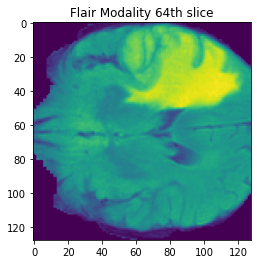

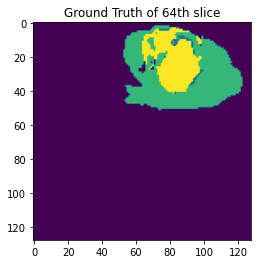

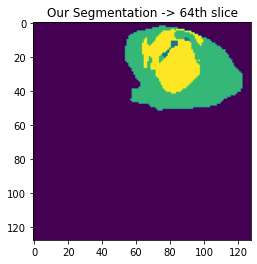

In [ ]:
x = all_images[181]
print("Results on image number 181")
folder_path = path + '/' + x;
modalities = os.listdir(folder_path)
modalities.sort()
data = np.zeros((240,240,155,4))
#data = []
w = 0
for j in range(len(modalities)):
  #print(modalities[j])

  image_path = folder_path + '/' + modalities[j]
  if not(image_path.find('seg.nii') == -1):
    img = nib.load(image_path);
    image_data2 = img.get_data()
    image_data2 = np.asarray(image_data2)
    print("Entered ground truth")
  else:
    img = nib.load(image_path);
    image_data = img.get_data()
    image_data = np.asarray(image_data)
    image_data = standardize(image_data)
    data[:,:,:,w] = image_data
    print("Entered modality")
    w = w+1

print(data.shape)
print(image_data2.shape)  

reshaped_data=data[56:184,75:203,13:141,:]
reshaped_data=reshaped_data.reshape(1,128,128,128,4)
reshaped_image_data2=image_data2[56:184,75:203,13:141]


reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
reshaped_image_data2[reshaped_image_data2==4] = 3
#hello = reshaped_image_data2.flatten()
#y_to = keras.utils.to_categorical(y_to,num_classes=2)
print(reshaped_image_data2.shape)
#print(hello[hello==3].shape)
#print("Number of classes",np.unique(hello))
#class_weights = class_weight.compute_class_weight('balanced',np.unique(hello),hello)
#print(class_weights)

#reshaped_image_data2 = keras.utils.to_categorical(reshaped_image_data2, num_classes = 4)

print(reshaped_data.shape)
print(reshaped_image_data2.shape)
print(type(reshaped_data))

Y_hat = model.predict(x=reshaped_data)
Y_hat = np.argmax(Y_hat,axis=-1)
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
img = reshaped_data[0,:,:,64,0]
imgplot = plt.imshow(img)
plt.title('Flair Modality 64th slice')
plt.savefig('Flair')
plt.show()

img2 = reshaped_image_data2[0,:,:,64]
imgplot2 = plt.imshow(img2)
plt.title('Ground Truth of 64th slice')
plt.savefig('Ground_Truth')
plt.show()

img3 = Y_hat[0,:,:,64]
imgplot3 = plt.imshow(img3)
plt.title('Our Segmentation -> 64th slice')
plt.savefig('Our Segmentation')
plt.show()

